# Import required libraries
# OpenCV for image processing, NumPy for numerical operations, and Matplotlib for visualization.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load the two images to be stitched together.
# Ensure the images are present in the working directory.


In [4]:
image1_path = "panorama1.jpeg"
image2_path = "panorama2.jpeg"

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)


# Convert images to grayscale for feature detection.


In [5]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


# Use ORB (Oriented FAST and Rotated BRIEF) to detect keypoints and compute descriptors.
# Keypoints help in finding common points between two images.


In [6]:
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)


# Draw keypoints detected on both images and display them.


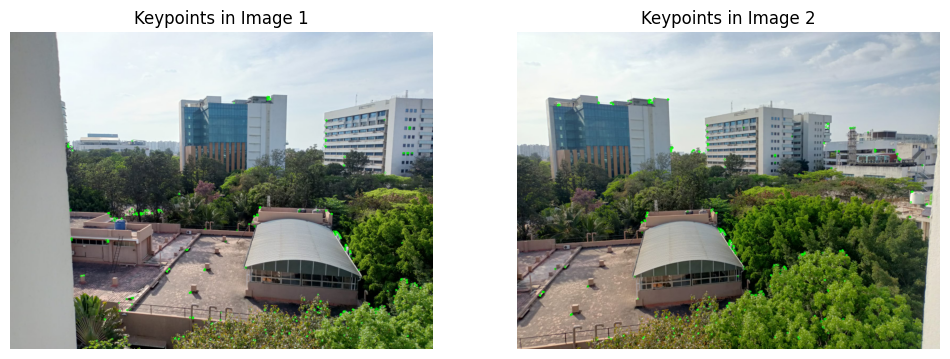

In [7]:
image1_kp = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0), flags=0)
image2_kp = cv2.drawKeypoints(image2, keypoints2, None, color=(0, 255, 0), flags=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 2")
plt.axis("off")
plt.show()


# Use BFMatcher to find matches between descriptors of both images.
# Sort matches based on distance (lower distance means better match).


In [8]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)


# Draw the first 50 matches between the images to verify feature matching.


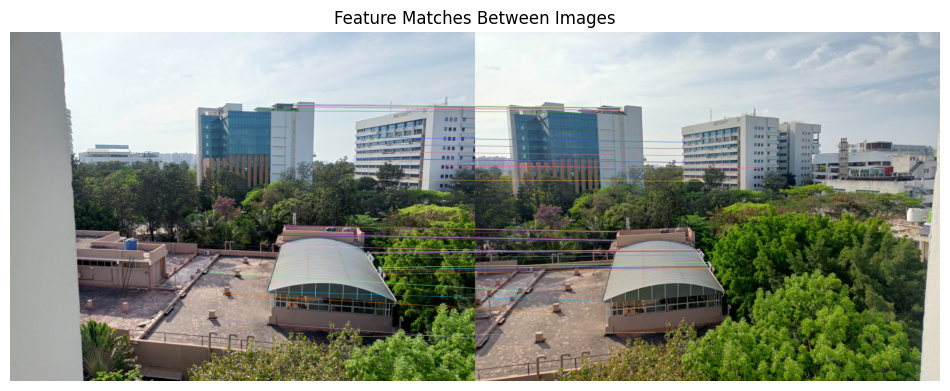

In [9]:
match_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches Between Images")
plt.axis("off")
plt.show()


# Extract matched keypoint locations and compute the Homography matrix.
# Homography helps in aligning one image onto another.


In [10]:
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)


# Use the homography matrix to warp the second image onto the first.


In [11]:
height1, width1 = image1.shape[:2]
height2, width2 = image2.shape[:2]

warped_image2 = cv2.warpPerspective(image2, H, (width1 + width2, height1))
warped_image2[0:height1, 0:width1] = image1


# Convert the warped image to grayscale and remove black regions.
# This ensures the final panorama is cropped properly.


In [12]:
gray_warped = cv2.cvtColor(warped_image2, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_warped, 1, 255, cv2.THRESH_BINARY)

x, y, w, h = cv2.boundingRect(mask)
stitched_cropped = warped_image2[y:y+h, x:x+w]


# Save the final stitched panorama image


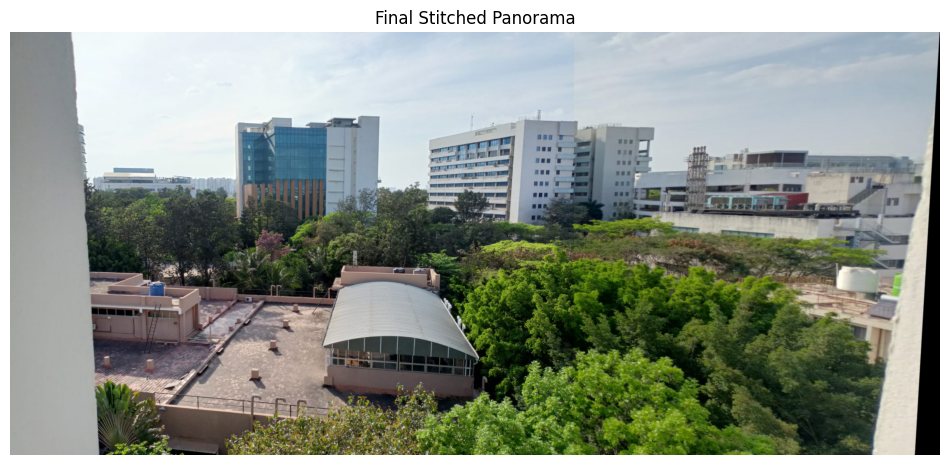

True

In [14]:
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(stitched_cropped, cv2.COLOR_BGR2RGB))
plt.title("Final Stitched Panorama")
plt.axis("off")
plt.show()
output_path = "stitched_panorama.jpeg"
cv2.imwrite(output_path, stitched_cropped)
